<a href="https://colab.research.google.com/github/ojimenezn/ml-interpretability/blob/main/interpretability_lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Omar A. Jiménez-Negrón
### May 25, 2020
### ESMA4016 Final Project
## **ML INTERPETABILITY WITH LIME**


In [ ]:
!pip install tensorflow==2.0.0
import tensorflow as tf
tf.__version__   # To ensure we are using TensorFlow 2.0.0, some bugs with TensorFlow 2.2.2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
pio.templates.default = 'plotly_white'

## Importing the data from Google Drive

The file is archived as a ZIP file in my Google Drive. It is already divided into train-test folders (80% train-20% test).

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q':"title='DogsWolves.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('DogsWolves.zip')

!unzip DogsWolves.zip

In [ ]:
PATH = '/content/DogsWolves'
os.listdir(PATH)

['train', 'test', '.DS_Store']

##### Note: .DS_Store is simply a file that is generated in Mac OS X. 

In [ ]:
train_dir = os.path.join(PATH,
                         'train')
test_dir = os.path.join(PATH,
                        'test')

In [ ]:
train_dogs_dir = os.path.join(train_dir,
                                'dogs')
train_wolves_dir = os.path.join(train_dir,
                                   'wolves')

test_dogs_dir = os.path.join(test_dir,
                               'dogs')
test_wolves_dir = os.path.join(test_dir,
                                  'wolves')

Now we can inspect the dimensions of the data, to ensure the dataset was loaded correctly. 

In [ ]:
len(os.listdir(train_dogs_dir))

803

In [ ]:
len(os.listdir(test_wolves_dir))

201


## Data Preprocessing

In [ ]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
batch_size = 256

In [ ]:
image_gen_train = ImageDataGenerator(rescale=1./255)  # Normalizing training data 

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 1602 images belonging to 2 classes.


In [ ]:
image_gen_test = ImageDataGenerator(rescale=1./255) # Normalizing test data

In [ ]:
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                   directory=test_dir,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                   class_mode='categorical')

Found 400 images belonging to 2 classes.


In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
# Defining a function to plot images 
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

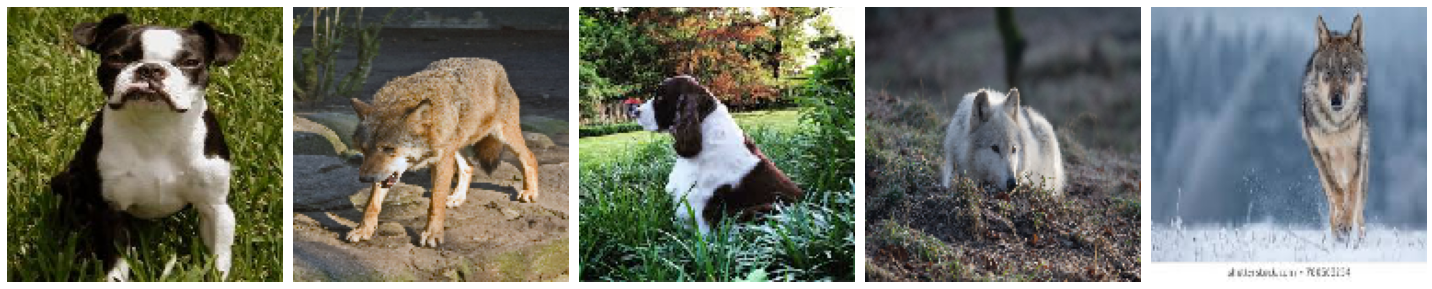

In [ ]:
plotImages(sample_training_images[:5])

## Convolutional Neural Network (CNN) 

In [ ]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

## CNN Training 

In [ ]:
num_dogs_train = len(os.listdir(train_dogs_dir))
num_wolves_train = len(os.listdir(train_wolves_dir))

num_dogs_test = len(os.listdir(test_dogs_dir))
num_wolves_test = len(os.listdir(test_wolves_dir))

total_train = num_dogs_train + num_wolves_train 
total_test = num_dogs_test + num_wolves_test 

In [ ]:
batch_size = 128
epochs = 10

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=total_test // batch_size,
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=4
    )]
)

Epoch 1/10
12/12 [==============================] - 125s 10s/step - loss: 3.1404 - accuracy: 0.4951 - val_loss: 0.6929 - val_accuracy: 0.4893
Epoch 2/10
12/12 [==============================] - 113s 9s/step - loss: 0.6839 - accuracy: 0.5580 - val_loss: 0.6747 - val_accuracy: 0.5610
Epoch 3/10
12/12 [==============================] - 114s 10s/step - loss: 0.6539 - accuracy: 0.6110 - val_loss: 0.6547 - val_accuracy: 0.5915
Epoch 4/10
12/12 [==============================] - 98s 8s/step - loss: 0.6353 - accuracy: 0.6293 - val_loss: 0.6287 - val_accuracy: 0.6616
Epoch 5/10
12/12 [==============================] - 111s 9s/step - loss: 0.5977 - accuracy: 0.6761 - val_loss: 0.6240 - val_accuracy: 0.6646
Epoch 6/10
12/12 [==============================] - 113s 9s/step - loss: 0.5562 - accuracy: 0.7186 - val_loss: 0.5968 - val_accuracy: 0.6768
Epoch 7/10
12/12 [==============================] - 102s 8s/step - loss: 0.5208 - accuracy: 0.7359 - val_loss: 0.5862 - val_accuracy: 0.6921
Epoch 8/10
1

Note: This may take a couple of minutes, due to the type and size of the dataset.

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['accuracy'],
                         mode='lines+markers',
                         name='Training accuracy'))
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['val_accuracy'],
                         mode='lines+markers',
                         name='Test accuracy'))
fig.update_layout(title='Accuracy',
                  xaxis=dict(title='Epoch'),
                  yaxis=dict(title='Percentage'))
fig.show()

The difference betwen training and test accuracies is small, suggesting there is not significant overfitting. We will now take a look at the LIME explanations.  


# LIME 

Using TensorFlow backend.


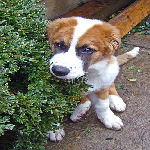

In [ ]:
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
image_raw = load_img("DogsWolves/test/dogs/D838.jpg", target_size=(150, 150))
image_raw

In [ ]:
# Convert to numpy array, reshape and preprocess
image = img_to_array(image_raw)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

In [ ]:
predictions = model.predict(image)

In [ ]:
model.predict(image).argsort()[0, -5:][::-1]

array([1, 0])

The model predicts the sample belongs to class (dogs), which is correct!

In [ ]:
!pip install lime

In [ ]:
from lime.lime_image import LimeImageExplainer
explainer = LimeImageExplainer()
explanation = explainer.explain_instance(image[0], model.predict, 
                                         top_labels=2, num_samples=100,
                                         random_seed=42)

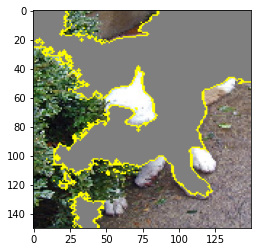

In [ ]:
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=100, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

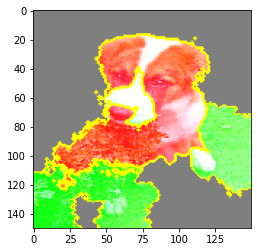

In [ ]:
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=8, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

However, as may be appreciated, the explanation is not convincing. It is simply looking at the grass (in fact, it is considering the face of the dog as evidence for *not* classifying it as a dog)!

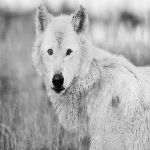

In [ ]:
image_raw2 = load_img("DogsWolves/test/wolves/W831.jpg", target_size=(150, 150))
image_raw2

In [ ]:
image = img_to_array(image_raw2)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
predictions = model.predict(image)
model.predict(image).argsort()[0, -5:][::-1]

array([1, 0])

The model predicts the sample belongs to class (dogs), which is incorrect! Let's look at the explanation this time. 

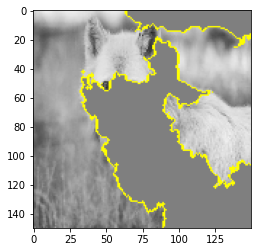

In [ ]:
explainer = LimeImageExplainer()
explanation = explainer.explain_instance(image[0], model.predict, 
                                         top_labels=2, num_samples=100,
                                         random_seed=42)
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=100, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

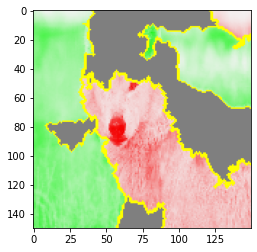

In [ ]:
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=8, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Again, the model is only looking at the background to make the classification! Although this is a classifier with a (good) test accuracy of 75%, you should *not* trust it!